In [2]:
import cantera as ct
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt

In [3]:
gas=ct.Solution('C:\\Users\\Wan\\cantera\\han\\chem_annotated.cti')

In [4]:
gas()


  gas:

       temperature             300  K
          pressure          101325  Pa
           density         1.62277  kg/m^3
  mean mol. weight          39.948  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy          962.61        3.845e+04     J
   internal energy          -61477       -2.456e+06     J
           entropy          3879.4         1.55e+05     J/K
    Gibbs function     -1.1629e+06       -4.645e+07     J
 heat capacity c_p          520.33        2.079e+04     J/K
 heat capacity c_v           312.2        1.247e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                Ar              1                1         -18.6237
     [  +53 minor]              0                0



In [8]:
gas.reactions()

[<ThreeBodyReaction: H2(9) + M <=> 2 H(15) + M>,
 <ElementaryReaction: Ar + H2(9) <=> Ar + 2 H(15)>,
 <ElementaryReaction: H2(9) + OH(19) <=> H(15) + H2O(6)>,
 <ThreeBodyReaction: H2O(6) + M <=> H(15) + OH(19) + M>,
 <ElementaryReaction: 2 H2O(6) <=> H(15) + H2O(6) + OH(19)>,
 <ElementaryReaction: 2 OH(19) <=> H2(9) + O2(7)>,
 <ElementaryReaction: CH3(13) + OH(19) <=> CH3OH(5)>,
 <ElementaryReaction: 2 CH3(13) <=> C2H6(11)>,
 <ElementaryReaction: C2H5(16) + H(15) <=> C2H6(11)>,
 <ElementaryReaction: H(15) + HCO(17) <=> CH2O(12)>,
 <ElementaryReaction: CO(10) + H2(9) <=> CH2O(12)>,
 <ElementaryReaction: C2H5(16) + CH3(13) <=> C3H8(14)>,
 <ElementaryReaction: C2H4(20) + H(15) <=> C2H5(16)>,
 <ElementaryReaction: CO(10) + H(15) <=> HCO(17)>,
 <ElementaryReaction: CH3(13) + HCO(17) <=> CH3CHO(18)>,
 <ElementaryReaction: HCO(17) + OH(19) <=> CO(10) + H2O(6)>,
 <ElementaryReaction: C2H6(11) + OH(19) <=> C2H5(16) + H2O(6)>,
 <ElementaryReaction: CH2O(12) + OH(19) <=> H2O(6) + HCO(17)>,
 <Elem

In [5]:
gas.species()

[<Species Ar>,
 <Species Ne>,
 <Species N2>,
 <Species H4N2O2(2)>,
 <Species NH2OH(3)>,
 <Species HNO3(4)>,
 <Species CH3OH(5)>,
 <Species H2O(6)>,
 <Species O2(7)>,
 <Species CO2(8)>,
 <Species H2(9)>,
 <Species CO(10)>,
 <Species C2H6(11)>,
 <Species CH2O(12)>,
 <Species CH3(13)>,
 <Species C3H8(14)>,
 <Species H(15)>,
 <Species C2H5(16)>,
 <Species HCO(17)>,
 <Species CH3CHO(18)>,
 <Species OH(19)>,
 <Species C2H4(20)>,
 <Species CH4(23)>,
 <Species O(32)>,
 <Species H3N2O(36)>,
 <Species NH2NHJ(37)>,
 <Species H3N2O2(38)>,
 <Species NH2(D)(40)>,
 <Species H3N2O2(42)>,
 <Species NH2OJ(43)>,
 <Species HNOHJ(44)>,
 <Species NO2J(45)>,
 <Species NO3J(46)>,
 <Species CH2OH(49)>,
 <Species CH2(S)(50)>,
 <Species NOJ(242)>,
 <Species HNO2(246)>,
 <Species HONO(248)>,
 <Species ONOOH(297)>,
 <Species N2O4(305)>,
 <Species NH3(313)>,
 <Species H4N2(332)>,
 <Species HNO(333)>,
 <Species HNO(334)>,
 <Species H3NO2(366)>,
 <Species NOHJJ(382)>,
 <Species H3NO2(398)>,
 <Species OCO(494)>,
 <Spe

In [118]:
"""
This example solves a plug flow reactor problem, where the chemistry is
surface chemistry. The specific problem simulated is the partial oxidation of
methane over a platinum catalyst in a packed bed reactor.
"""

import csv

import cantera as ct

# unit conversion factors to SI
cm = 0.01
minute = 60.0

#######################################################################
# Input Parameters
#######################################################################

tc = 600.0  # Temperature in Celsius
length = 0.3 * cm  # Catalyst bed length
area = 1.0 * cm**2  # Catalyst bed area
cat_area_per_vol = 1000.0 / cm  # Catalyst particle surface area per unit volume
velocity = 400.0 * cm / minute  # gas velocity (multiplied by 10)
porosity = 0.3  # Catalyst bed porosity

# input file containing the surface reaction mechanism
cti_file = 'chem_annotated.cti'

output_filename = 'surf_pfr_output.csv'

# The PFR will be simulated by a chain of 'NReactors' stirred reactors.
NReactors = 401
dt = 1.0

#####################################################################

t = tc + 273.15  # convert to Kelvin

# import the gas model and set the initial conditions
gas = ct.Solution(cti_file, 'gas')

gas.TPX = t, ct.one_atm, 'H4N2O2(2):0.14, NH2OH(3):0.3, HNO3(4):0.3, CH3OH(5):0.16, H2O(6):0.04'

# import the surface model
surf = ct.Interface(cti_file,'surface1', [gas])
surf.TP = t, ct.one_atm

rlen = length/(NReactors-1)
rvol = area * rlen * porosity

outfile = open(output_filename,'w')
writer = csv.writer(outfile)
writer.writerow(['Distance (mm)', 'T (C)', 'P (atm)'] +
                gas.species_names + surf.species_names)

# catalyst area in one reactor
cat_area = cat_area_per_vol * rvol

mass_flow_rate = velocity * gas.density * area

# The plug flow reactor is represented by a linear chain of zero-dimensional
# reactors. The gas at the inlet to the first one has the specified inlet
# composition, and for all others the inlet composition is fixed at the
# composition of the reactor immediately upstream. Since in a PFR model there
# is no diffusion, the upstream reactors are not affected by any downstream
# reactors, and therefore the problem may be solved by simply marching from
# the first to last reactor, integrating each one to steady state.

TDY = gas.TDY
cov = surf.coverages

print('    distance       H4N2O2(2)   NH2OH(3)  HNO3(4)   CH3OH(5)')

# create a new reactor
gas.TDY = TDY
r = ct.IdealGasReactor(gas, energy='off')
r.volume = rvol

# create a reservoir to represent the reactor immediately upstream. Note
# that the gas object is set already to the state of the upstream reactor
upstream = ct.Reservoir(gas, name='upstream')

# create a reservoir for the reactor to exhaust into. The composition of
# this reservoir is irrelevant.
downstream = ct.Reservoir(gas, name='downstream')

# Add the reacting surface to the reactor. The area is set to the desired
# catalyst area in the reactor.
rsurf = ct.ReactorSurface(surf, r, A=cat_area)

# The mass flow rate into the reactor will be fixed by using a
# MassFlowController object.
m = ct.MassFlowController(upstream, r, mdot=mass_flow_rate)

# We need an outlet to the downstream reservoir. This will determine the
# pressure in the reactor. The value of K will only affect the transient
# pressure difference.
v = ct.PressureController(r, downstream, master=m, K=1e-5)

sim = ct.ReactorNet([r])
sim.max_err_test_fails = 12

# set relative and absolute tolerances on the simulation
sim.rtol = 1.0e-9
sim.atol = 1.0e-21

for n in range(NReactors):
    # Set the state of the reservoir to match that of the previous reactor
    gas.TDY = r.thermo.TDY
    upstream.syncState()
    sim.reinitialize()
    sim.advance_to_steady_state()
    dist = n * rlen * 1.0e3   # distance in mm

    if not n % 10:
        print('  {0:10f}  {1:10f}  {2:10f}  {3:10f} {4:10f}'.format(dist, *gas['H4N2O2(2)','NH2OH(3)','HNO3(4)','CH3OH(5)'].X))

    # write the gas mole fractions and surface coverages vs. distance
    writer.writerow([dist, r.T - 273.15, r.thermo.P/ct.one_atm] +
                    list(gas.X) + list(surf.coverages))

outfile.close()
print("Results saved to '{0}'".format(output_filename))

    distance       H4N2O2(2)   NH2OH(3)  HNO3(4)   CH3OH(5)
    0.000000    0.093406    0.181053    0.107587   0.125901
    0.075000    0.044603    0.099352    0.000037   0.086119
    0.150000    0.034870    0.089023    0.000006   0.076252
    0.225000    0.029459    0.083164    0.000003   0.070297
    0.300000    0.025904    0.079253    0.000002   0.066164
    0.375000    0.023347    0.076403    0.000001   0.063072
    0.450000    0.021399    0.074211    0.000001   0.060646
    0.525000    0.019854    0.072459    0.000001   0.058679
    0.600000    0.018592    0.071020    0.000000   0.057046
    0.675000    0.017536    0.069812    0.000000   0.055664
    0.750000    0.016636    0.068780    0.000000   0.054478
    0.825000    0.015858    0.067888    0.000000   0.053448
    0.900000    0.015177    0.067106    0.000000   0.052544
    0.975000    0.014573    0.066415    0.000000   0.051744
    1.050000    0.014034    0.065798    0.000000   0.051031
    1.125000    0.013548    0.065244    

CanteraError: 
***********************************************************************
CanteraError thrown by CVodesIntegrator::step:
CVodes error encountered. Error code: -10
Exceptions caught during RHS evaluation:

***********************************************************************
CanteraError thrown by checkFinite:
ydot contains non-finite elements:

ydot[0] = inf
ydot[3] = -inf
ydot[4] = -inf
ydot[5] = -inf
ydot[6] = -inf
ydot[7] = -inf
ydot[8] = -inf
ydot[9] = -inf
ydot[10] = -inf
ydot[11] = -inf
ydot[12] = -inf
ydot[13] = -inf
ydot[14] = -inf
ydot[15] = -inf
ydot[16] = -inf
ydot[17] = -inf
ydot[18] = -inf
ydot[19] = -inf
ydot[20] = -nan
ydot[21] = -nan
ydot[22] = -inf
ydot[23] = -nan
ydot[24] = -inf
ydot[25] = -inf
ydot[26] = -inf
ydot[27] = -nan
ydot[28] = -inf
ydot[29] = -nan
ydot[30] = -nan
ydot[31] = -nan
ydot[32] = -nan
ydot[33] = -inf
ydot[34] = -nan
ydot[35] = -inf
ydot[36] = -nan
ydot[37] = -inf
ydot[38] = -nan
ydot[39] = -inf
ydot[40] = -inf
ydot[41] = -inf
ydot[42] = -inf
ydot[43] = -inf
ydot[44] = -inf
ydot[45] = -inf
ydot[46] = -inf
ydot[47] = -inf
ydot[48] = -nan
ydot[49] = -inf
ydot[50] = -nan
ydot[51] = -inf
ydot[52] = -inf
ydot[53] = inf
ydot[54] = -inf
ydot[55] = -inf
ydot[56] = -inf
ydot[57] = -nan
ydot[59] = -inf
ydot[61] = -inf
ydot[68] = inf
ydot[69] = -inf
ydot[74] = -inf
ydot[80] = -inf
***********************************************************************


***********************************************************************
CanteraError thrown by checkFinite:
ydot contains non-finite elements:

ydot[0] = inf
ydot[3] = -inf
ydot[4] = -inf
ydot[5] = -inf
ydot[6] = -inf
ydot[7] = -inf
ydot[8] = -inf
ydot[9] = -inf
ydot[10] = -inf
ydot[11] = -inf
ydot[12] = -inf
ydot[13] = -inf
ydot[14] = -inf
ydot[15] = -inf
ydot[16] = -inf
ydot[17] = -inf
ydot[18] = -inf
ydot[19] = -inf
ydot[20] = -nan
ydot[21] = -nan
ydot[22] = -inf
ydot[23] = -nan
ydot[24] = -inf
ydot[25] = -inf
ydot[26] = -inf
ydot[27] = -nan
ydot[28] = -inf
ydot[29] = -nan
ydot[30] = -nan
ydot[31] = -nan
ydot[32] = -nan
ydot[33] = -inf
ydot[34] = -nan
ydot[35] = -inf
ydot[36] = -nan
ydot[37] = -inf
ydot[38] = -nan
ydot[39] = -inf
ydot[40] = -inf
ydot[41] = -inf
ydot[42] = -inf
ydot[43] = -inf
ydot[44] = -inf
ydot[45] = -inf
ydot[46] = -inf
ydot[47] = -inf
ydot[48] = -nan
ydot[49] = -inf
ydot[50] = -nan
ydot[51] = -inf
ydot[52] = -inf
ydot[53] = inf
ydot[54] = -inf
ydot[55] = -inf
ydot[56] = -inf
ydot[57] = -nan
ydot[59] = -inf
ydot[61] = -inf
ydot[68] = inf
ydot[69] = -inf
ydot[74] = -inf
ydot[80] = -inf
***********************************************************************


***********************************************************************
CanteraError thrown by checkFinite:
ydot contains non-finite elements:

ydot[0] = inf
ydot[3] = -inf
ydot[4] = -inf
ydot[5] = -inf
ydot[6] = -inf
ydot[7] = -inf
ydot[8] = -inf
ydot[9] = -inf
ydot[10] = -inf
ydot[11] = -inf
ydot[12] = -inf
ydot[13] = -inf
ydot[14] = -inf
ydot[15] = -inf
ydot[16] = -inf
ydot[17] = -inf
ydot[18] = -inf
ydot[19] = -inf
ydot[20] = -nan
ydot[21] = -nan
ydot[22] = -inf
ydot[23] = -nan
ydot[24] = -inf
ydot[25] = -inf
ydot[26] = -inf
ydot[27] = -nan
ydot[28] = -inf
ydot[29] = -nan
ydot[30] = -nan
ydot[31] = -nan
ydot[32] = -nan
ydot[33] = -inf
ydot[34] = -nan
ydot[35] = -inf
ydot[36] = -nan
ydot[37] = -inf
ydot[38] = -nan
ydot[39] = -inf
ydot[40] = -inf
ydot[41] = -inf
ydot[42] = -inf
ydot[43] = -inf
ydot[44] = -inf
ydot[45] = -inf
ydot[46] = -inf
ydot[47] = -inf
ydot[48] = -nan
ydot[49] = -inf
ydot[50] = -nan
ydot[51] = -inf
ydot[52] = -inf
ydot[53] = inf
ydot[54] = -inf
ydot[55] = -inf
ydot[56] = -inf
ydot[57] = -nan
ydot[59] = -inf
ydot[61] = -inf
ydot[68] = inf
ydot[69] = -inf
ydot[74] = -inf
ydot[80] = -inf
***********************************************************************


***********************************************************************
CanteraError thrown by checkFinite:
ydot contains non-finite elements:

ydot[0] = inf
ydot[3] = -inf
ydot[4] = -inf
ydot[5] = -inf
ydot[6] = -inf
ydot[7] = -inf
ydot[8] = -inf
ydot[9] = -inf
ydot[10] = -inf
ydot[11] = -inf
ydot[12] = -inf
ydot[13] = -inf
ydot[14] = -inf
ydot[15] = -inf
ydot[16] = -inf
ydot[17] = -inf
ydot[18] = -inf
ydot[19] = -inf
ydot[20] = -nan
ydot[21] = -nan
ydot[22] = -inf
ydot[23] = -nan
ydot[24] = -inf
ydot[25] = -inf
ydot[26] = -inf
ydot[27] = -nan
ydot[28] = -inf
ydot[29] = -nan
ydot[30] = -nan
ydot[31] = -nan
ydot[32] = -nan
ydot[33] = -inf
ydot[34] = -nan
ydot[35] = -inf
ydot[36] = -nan
ydot[37] = -inf
ydot[38] = -nan
ydot[39] = -inf
ydot[40] = -inf
ydot[41] = -inf
ydot[42] = -inf
ydot[43] = -inf
ydot[44] = -inf
ydot[45] = -inf
ydot[46] = -inf
ydot[47] = -inf
ydot[48] = -nan
ydot[49] = -inf
ydot[50] = -nan
ydot[51] = -inf
ydot[52] = -inf
ydot[53] = inf
ydot[54] = -inf
ydot[55] = -inf
ydot[56] = -inf
ydot[57] = -nan
ydot[59] = -inf
ydot[61] = -inf
ydot[68] = inf
ydot[69] = -inf
ydot[74] = -inf
ydot[80] = -inf
***********************************************************************


***********************************************************************
CanteraError thrown by checkFinite:
ydot contains non-finite elements:

ydot[0] = inf
ydot[3] = -inf
ydot[4] = -inf
ydot[5] = -inf
ydot[6] = -inf
ydot[7] = -inf
ydot[8] = -inf
ydot[9] = -inf
ydot[10] = -inf
ydot[11] = -inf
ydot[12] = -inf
ydot[13] = -inf
ydot[14] = -inf
ydot[15] = -inf
ydot[16] = -inf
ydot[17] = -inf
ydot[18] = -inf
ydot[19] = -inf
ydot[20] = -nan
ydot[21] = -nan
ydot[22] = -inf
ydot[23] = -nan
ydot[24] = -inf
ydot[25] = -inf
ydot[26] = -inf
ydot[27] = -nan
ydot[28] = -inf
ydot[29] = -nan
ydot[30] = -nan
ydot[31] = -nan
ydot[32] = -nan
ydot[33] = -inf
ydot[34] = -nan
ydot[35] = -inf
ydot[36] = -nan
ydot[37] = -inf
ydot[38] = -nan
ydot[39] = -inf
ydot[40] = -inf
ydot[41] = -inf
ydot[42] = -inf
ydot[43] = -inf
ydot[44] = -inf
ydot[45] = -inf
ydot[46] = -inf
ydot[47] = -inf
ydot[48] = -nan
ydot[49] = -inf
ydot[50] = -nan
ydot[51] = -inf
ydot[52] = -inf
ydot[53] = inf
ydot[54] = -inf
ydot[55] = -inf
ydot[56] = -inf
ydot[57] = -nan
ydot[59] = -inf
ydot[61] = -inf
ydot[68] = inf
ydot[69] = -inf
ydot[74] = -inf
ydot[80] = -inf
***********************************************************************


***********************************************************************
CanteraError thrown by checkFinite:
ydot contains non-finite elements:

ydot[0] = inf
ydot[3] = -inf
ydot[4] = -inf
ydot[5] = -inf
ydot[6] = -inf
ydot[7] = -inf
ydot[8] = -inf
ydot[9] = -inf
ydot[10] = -inf
ydot[11] = -inf
ydot[12] = -inf
ydot[13] = -inf
ydot[14] = -inf
ydot[15] = -inf
ydot[16] = -inf
ydot[17] = -inf
ydot[18] = -inf
ydot[19] = -inf
ydot[20] = -nan
ydot[21] = -nan
ydot[22] = -inf
ydot[23] = -nan
ydot[24] = -inf
ydot[25] = -inf
ydot[26] = -inf
ydot[27] = -nan
ydot[28] = -inf
ydot[29] = -nan
ydot[30] = -nan
ydot[31] = -nan
ydot[32] = -nan
ydot[33] = -inf
ydot[34] = -nan
ydot[35] = -inf
ydot[36] = -nan
ydot[37] = -inf
ydot[38] = -nan
ydot[39] = -inf
ydot[40] = -inf
ydot[41] = -inf
ydot[42] = -inf
ydot[43] = -inf
ydot[44] = -inf
ydot[45] = -inf
ydot[46] = -inf
ydot[47] = -inf
ydot[48] = -nan
ydot[49] = -inf
ydot[50] = -nan
ydot[51] = -inf
ydot[52] = -inf
ydot[53] = inf
ydot[54] = -inf
ydot[55] = -inf
ydot[56] = -inf
ydot[57] = -nan
ydot[59] = -inf
ydot[61] = -inf
ydot[68] = inf
ydot[69] = -inf
ydot[74] = -inf
ydot[80] = -inf
***********************************************************************


***********************************************************************
CanteraError thrown by checkFinite:
ydot contains non-finite elements:

ydot[0] = inf
ydot[3] = -inf
ydot[4] = -inf
ydot[5] = -inf
ydot[6] = -inf
ydot[7] = -inf
ydot[8] = -inf
ydot[9] = -inf
ydot[10] = -inf
ydot[11] = -inf
ydot[12] = -inf
ydot[13] = -inf
ydot[14] = -inf
ydot[15] = -inf
ydot[16] = -inf
ydot[17] = -inf
ydot[18] = -inf
ydot[19] = -inf
ydot[20] = -nan
ydot[21] = -nan
ydot[22] = -inf
ydot[23] = -nan
ydot[24] = -inf
ydot[25] = -inf
ydot[26] = -inf
ydot[27] = -nan
ydot[28] = -inf
ydot[29] = -nan
ydot[30] = -nan
ydot[31] = -nan
ydot[32] = -nan
ydot[33] = -inf
ydot[34] = -nan
ydot[35] = -inf
ydot[36] = -nan
ydot[37] = -inf
ydot[38] = -nan
ydot[39] = -inf
ydot[40] = -inf
ydot[41] = -inf
ydot[42] = -inf
ydot[43] = -inf
ydot[44] = -inf
ydot[45] = -inf
ydot[46] = -inf
ydot[47] = -inf
ydot[48] = -nan
ydot[49] = -inf
ydot[50] = -nan
ydot[51] = -inf
ydot[52] = -inf
ydot[53] = inf
ydot[54] = -inf
ydot[55] = -inf
ydot[56] = -inf
ydot[57] = -nan
ydot[59] = -inf
ydot[61] = -inf
ydot[68] = inf
ydot[69] = -inf
ydot[74] = -inf
ydot[80] = -inf
***********************************************************************


***********************************************************************
CanteraError thrown by checkFinite:
ydot contains non-finite elements:

ydot[0] = inf
ydot[3] = -inf
ydot[4] = -inf
ydot[5] = -inf
ydot[6] = -inf
ydot[7] = -inf
ydot[8] = -inf
ydot[9] = -inf
ydot[10] = -inf
ydot[11] = -inf
ydot[12] = -inf
ydot[13] = -inf
ydot[14] = -inf
ydot[15] = -inf
ydot[16] = -inf
ydot[17] = -inf
ydot[18] = -inf
ydot[19] = -inf
ydot[20] = -nan
ydot[21] = -nan
ydot[22] = -inf
ydot[23] = -nan
ydot[24] = -inf
ydot[25] = -inf
ydot[26] = -inf
ydot[27] = -nan
ydot[28] = -inf
ydot[29] = -nan
ydot[30] = -nan
ydot[31] = -nan
ydot[32] = -nan
ydot[33] = -inf
ydot[34] = -nan
ydot[35] = -inf
ydot[36] = -nan
ydot[37] = -inf
ydot[38] = -nan
ydot[39] = -inf
ydot[40] = -inf
ydot[41] = -inf
ydot[42] = -inf
ydot[43] = -inf
ydot[44] = -inf
ydot[45] = -inf
ydot[46] = -inf
ydot[47] = -inf
ydot[48] = -nan
ydot[49] = -inf
ydot[50] = -nan
ydot[51] = -inf
ydot[52] = -inf
ydot[53] = inf
ydot[54] = -inf
ydot[55] = -inf
ydot[56] = -inf
ydot[57] = -nan
ydot[59] = -inf
ydot[61] = -inf
ydot[68] = inf
ydot[69] = -inf
ydot[74] = -inf
ydot[80] = -inf
***********************************************************************


***********************************************************************
CanteraError thrown by checkFinite:
ydot contains non-finite elements:

ydot[0] = inf
ydot[3] = -inf
ydot[4] = -inf
ydot[5] = -inf
ydot[6] = -inf
ydot[7] = -inf
ydot[8] = -inf
ydot[9] = -inf
ydot[10] = -inf
ydot[11] = -inf
ydot[12] = -inf
ydot[13] = -inf
ydot[14] = -inf
ydot[15] = -inf
ydot[16] = -inf
ydot[17] = -inf
ydot[18] = -inf
ydot[19] = -inf
ydot[20] = -nan
ydot[21] = -nan
ydot[22] = -inf
ydot[23] = -nan
ydot[24] = -inf
ydot[25] = -inf
ydot[26] = -inf
ydot[27] = -nan
ydot[28] = -inf
ydot[29] = -nan
ydot[30] = -nan
ydot[31] = -nan
ydot[32] = -nan
ydot[33] = -inf
ydot[34] = -nan
ydot[35] = -inf
ydot[36] = -nan
ydot[37] = -inf
ydot[38] = -nan
ydot[39] = -inf
ydot[40] = -inf
ydot[41] = -inf
ydot[42] = -inf
ydot[43] = -inf
ydot[44] = -inf
ydot[45] = -inf
ydot[46] = -inf
ydot[47] = -inf
ydot[48] = -nan
ydot[49] = -inf
ydot[50] = -nan
ydot[51] = -inf
ydot[52] = -inf
ydot[53] = -nan
ydot[54] = -inf
ydot[55] = -inf
ydot[56] = -inf
ydot[57] = -nan
ydot[59] = -inf
ydot[61] = -inf
ydot[68] = inf
ydot[69] = -inf
ydot[74] = -inf
ydot[80] = -inf
***********************************************************************


***********************************************************************
CanteraError thrown by checkFinite:
ydot contains non-finite elements:

ydot[0] = inf
ydot[3] = -inf
ydot[4] = -inf
ydot[5] = -inf
ydot[6] = -inf
ydot[7] = -inf
ydot[8] = -inf
ydot[9] = -inf
ydot[10] = -inf
ydot[11] = -inf
ydot[12] = -inf
ydot[13] = -inf
ydot[14] = -inf
ydot[15] = -inf
ydot[16] = -inf
ydot[17] = -inf
ydot[18] = -inf
ydot[19] = -inf
ydot[20] = -nan
ydot[21] = -nan
ydot[22] = -inf
ydot[23] = -nan
ydot[24] = -inf
ydot[25] = -inf
ydot[26] = -inf
ydot[27] = -nan
ydot[28] = -inf
ydot[29] = -nan
ydot[30] = -nan
ydot[31] = -nan
ydot[32] = -nan
ydot[33] = -inf
ydot[34] = -nan
ydot[35] = -inf
ydot[36] = -nan
ydot[37] = -inf
ydot[38] = -nan
ydot[39] = -inf
ydot[40] = -inf
ydot[41] = -inf
ydot[42] = -inf
ydot[43] = -inf
ydot[44] = -inf
ydot[45] = -inf
ydot[46] = -inf
ydot[47] = -inf
ydot[48] = -nan
ydot[49] = -inf
ydot[50] = -nan
ydot[51] = -inf
ydot[52] = -inf
ydot[53] = -nan
ydot[54] = -inf
ydot[55] = -inf
ydot[56] = -inf
ydot[57] = -nan
ydot[59] = -inf
ydot[61] = -inf
ydot[68] = inf
ydot[69] = -inf
ydot[74] = -inf
ydot[80] = -inf
***********************************************************************


At t = 49959.6 repeated recoverable right-hand side function errors.
Components with largest weighted error estimates:
3: -inf
4: -inf
5: -inf
6: -inf
7: -inf
8: -inf
9: -inf
10: -inf
11: -inf
12: -inf
***********************************************************************


In [ ]:
import pandas as pd

In [119]:
data = pd.read_csv(output_filename)
data

,Distance (mm),T (C),P (atm),Ar,Ne,N2,H4N2O2(2),NH2OH(3),HNO3(4),CH3OH(5),...,H3NOX(74),NO2X(75),NO3X(76),NO2OHX(77),CH3OX(78),CH3OX(79),CH4OX(80),NO2X(244),NOX(434),HNOX(906)
0,0.0000,600.0,1.0,-2.093570e-34,-5.418137e-34,3.085717e-109,0.093406,0.181053,1.075865e-01,0.125901,...,5.414303e-11,4.487558e-15,9.732384e-13,1.670944e-11,4.747546e-11,0.000042,1.635631e-12,2.661365e-15,0.000003,0.998519
1,0.0075,600.0,1.0,-7.385203e-35,-7.605592e-43,2.896195e-109,0.074814,0.141462,4.195878e-02,0.111320,...,1.073556e-09,8.147078e-14,5.333594e-12,1.653770e-10,1.749691e-10,0.000439,3.670101e-11,4.831598e-14,0.000115,0.999057
2,0.0150,600.0,1.0,-1.845496e-35,9.782833e-59,2.806888e-109,0.065912,0.125272,1.718618e-02,0.104372,...,8.352953e-09,4.732708e-13,1.175536e-11,5.951589e-10,3.281334e-10,0.001822,3.023340e-10,2.806575e-13,0.001206,0.996795
3,0.0225,600.0,1.0,1.569604e-34,9.595505e-59,2.753140e-109,0.060593,0.117272,7.208857e-03,0.100157,...,3.326525e-08,1.338124e-12,1.473066e-11,1.062014e-09,4.681401e-10,0.004239,1.234233e-09,7.933887e-13,0.005837,0.989747
4,0.0300,600.0,1.0,2.192154e-34,-7.516869e-35,2.714561e-109,0.056869,0.112539,3.073953e-03,0.097117,...,7.651848e-08,2.225416e-12,1.194249e-11,1.085493e-09,5.747539e-10,0.006587,2.868640e-09,1.319048e-12,0.015535,0.977587
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2.7000,600.0,1.0,2.844198e-26,7.349007e-27,9.136715e-27,0.008431,0.059610,3.739795e-09,0.044291,...,7.957886e-07,1.260267e-13,1.228055e-17,2.592951e-14,3.672980e-10,0.001167,2.568720e-08,7.404677e-14,0.938415,0.047036
361,2.7075,600.0,1.0,2.844012e-26,7.348560e-27,9.136118e-27,0.008417,0.059595,3.698170e-09,0.044277,...,7.956390e-07,1.252662e-13,1.212991e-17,2.564252e-14,3.672067e-10,0.001165,2.568072e-08,7.360017e-14,0.938558,0.046890
362,2.7150,600.0,1.0,2.843827e-26,7.346615e-27,9.135525e-27,0.008403,0.059580,3.657120e-09,0.044264,...,7.954897e-07,1.245124e-13,1.198158e-17,2.535946e-14,3.671157e-10,0.001163,2.567427e-08,7.315751e-14,0.938701,0.046746
363,2.7225,600.0,1.0,2.843644e-26,7.346143e-27,9.134936e-27,0.008389,0.059565,3.616633e-09,0.044250,...,7.953409e-07,1.237653e-13,1.183551e-17,2.508028e-14,3.670251e-10,0.001161,2.566785e-08,7.271876e-14,0.938842,0.046602


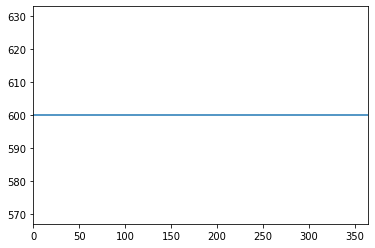

In [120]:
data['T (C)'].plot()

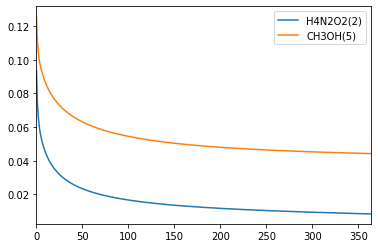

In [121]:
data[['H4N2O2(2)', 'CH3OH(5)']].plot()

In [122]:
specs = list(data.columns)
specs = specs[5:]
specs

['N2',
 'H4N2O2(2)',
 'NH2OH(3)',
 'HNO3(4)',
 'CH3OH(5)',
 'H2O(6)',
 'O2(7)',
 'CO2(8)',
 'H2(9)',
 'CO(10)',
 'C2H6(11)',
 'CH2O(12)',
 'CH3(13)',
 'C3H8(14)',
 'H(15)',
 'C2H5(16)',
 'HCO(17)',
 'CH3CHO(18)',
 'OH(19)',
 'C2H4(20)',
 'CH4(23)',
 'O(32)',
 'H3N2O(36)',
 'NH2NHJ(37)',
 'H3N2O2(38)',
 'NH2(D)(40)',
 'H3N2O2(42)',
 'NH2OJ(43)',
 'HNOHJ(44)',
 'NO2J(45)',
 'NO3J(46)',
 'CH2OH(49)',
 'CH2(S)(50)',
 'NOJ(242)',
 'HNO2(246)',
 'HONO(248)',
 'ONOOH(297)',
 'N2O4(305)',
 'NH3(313)',
 'H4N2(332)',
 'HNO(333)',
 'HNO(334)',
 'H3NO2(366)',
 'NOHJJ(382)',
 'H3NO2(398)',
 'OCO(494)',
 'S(496)',
 'S(502)',
 'ONCO(503)',
 'H2N2O(622)',
 'S(704)',
 'S(1246)',
 'X(1)',
 'HX(21)',
 'OX(22)',
 'CH3X(24)',
 'HOX(25)',
 'H2OX(26)',
 'CO2X(27)',
 'OCX(28)',
 'CX(29)',
 'CH2X(30)',
 'CHX(31)',
 '*ONN(63)',
 '*NN(65)',
 '*N(68)',
 '*NNOO(70)',
 'SX(71)',
 '*ON(72)',
 '*NO(73)',
 'H3NOX(74)',
 'NO2X(75)',
 'NO3X(76)',
 'NO2OHX(77)',
 'CH3OX(78)',
 'CH3OX(79)',
 'CH4OX(80)',
 'NO2X(244)',
 'N

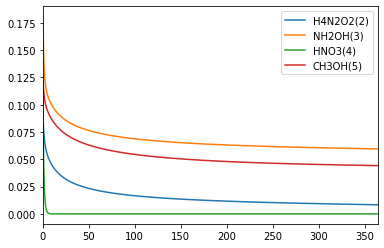

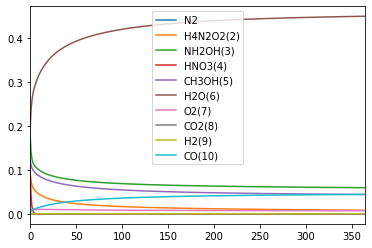

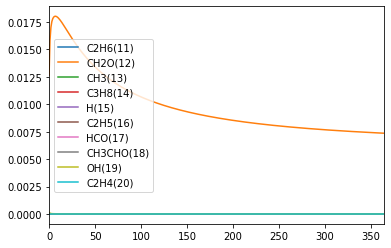

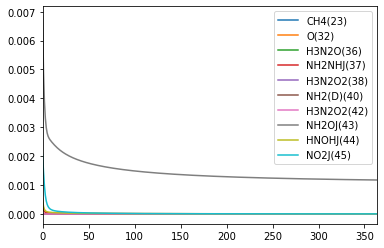

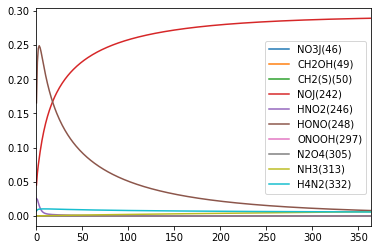

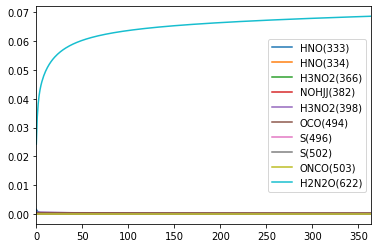

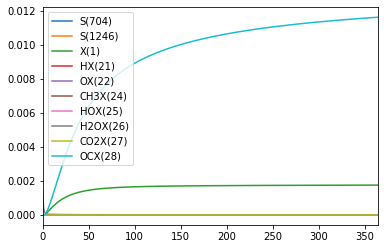

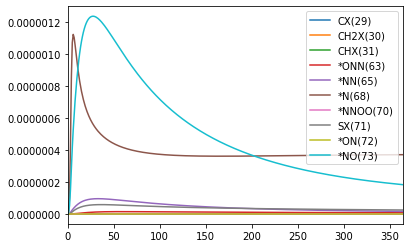

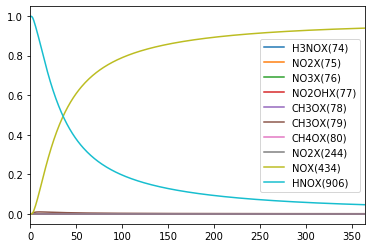

In [123]:
data[specs[1:5]].plot()

for i in range(0,len(specs),10):
    data[specs[i:i+10]].plot()

In [124]:
gas.species('NOJ(242)').composition

{'N': 1.0, 'O': 1.0}

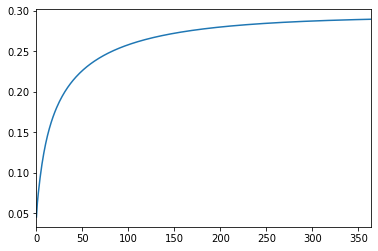

In [125]:
data['NOJ(242)'].plot()

In [126]:
(data[specs].max()>0.01)

N2           False
H4N2O2(2)     True
NH2OH(3)      True
HNO3(4)       True
CH3OH(5)      True
             ...  
CH3OX(79)     True
CH4OX(80)    False
NO2X(244)    False
NOX(434)      True
HNOX(906)     True
Length: 80, dtype: bool

In [90]:
data.loc[0]

Distance (mm)    0.000000e+00
T (C)            8.000000e+02
P (atm)          1.000000e+00
Ar               3.377014e-34
Ne               2.074942e-37
                     ...     
CH3OX(79)        1.846013e-03
CH4OX(80)        1.719304e-08
NO2X(244)        6.383125e-11
NOX(434)         6.282688e-03
HNOX(906)        9.867941e-01
Name: 0, Length: 85, dtype: float64